In [2]:
!pip install keras

    100% |################################| 337kB 4.4MB/s eta 0:00:01
    100% |################################| 256kB 4.6MB/s eta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /root/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml


In [4]:
!pip install flask

    100% |################################| 92kB 3.7MB/s ta 0:00:011
    100% |################################| 71kB 10.0MB/s ta 0:00:01
    100% |################################| 51kB 10.8MB/s ta 0:00:01
  Running setup.py bdist_wheel for itsdangerous ... done
  Stored in directory: /root/.cache/pip/wheels/fc/a8/66/24d655233c757e178d45dea2de22a04c6d92766abfb741129a
Successfully built itsdangerous


In [31]:
!pip install requests

    100% |################################| 92kB 3.6MB/s ta 0:00:011
    100% |################################| 153kB 5.7MB/s eta 0:00:01
    100% |################################| 61kB 13.2MB/s ta 0:00:01
    100% |################################| 143kB 10.3MB/s ta 0:00:01
    100% |################################| 133kB 10.1MB/s ta 0:00:01


In [2]:
from resnet152 import ResNet152
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

import numpy as np
import timeit as t
import base64
import json
from PIL import Image, ImageOps
from io import BytesIO

from flask import Flask, request
import requests

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%%time
model = ResNet152(weights='imagenet')

CPU times: user 28.5 s, sys: 2.61 s, total: 31.1 s
Wall time: 30.6 s


In [4]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2 (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9408        conv1_zeropadding[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
scale_conv

scale4b20_branch2c (Scale)      (None, 14, 14, 1024) 2048        bn4b20_branch2c[0][0]            
__________________________________________________________________________________________________
res4b20 (Add)                   (None, 14, 14, 1024) 0           scale4b20_branch2c[0][0]         
                                                                 res4b19_relu[0][0]               
__________________________________________________________________________________________________
res4b20_relu (Activation)       (None, 14, 14, 1024) 0           res4b20[0][0]                    
__________________________________________________________________________________________________
res4b21_branch2a (Conv2D)       (None, 14, 14, 256)  262144      res4b20_relu[0][0]               
__________________________________________________________________________________________________
bn4b21_branch2a (BatchNormaliza (None, 14, 14, 256)  1024        res4b21_branch2a[0][0]           
__________

(448, 448)


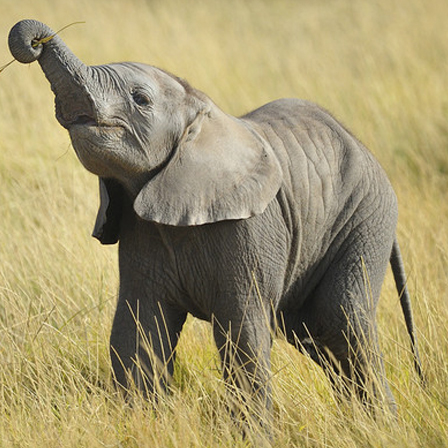

In [5]:
img_path = 'elephant.jpg'
print(Image.open(img_path).size)
Image.open(img_path)

In [6]:
%%time
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
print('Predicted:', decode_predictions(preds))

Predicted: [[('n02504458', 'African_elephant', 0.6228388), ('n01871265', 'tusker', 0.28300098), ('n02504013', 'Indian_elephant', 0.09257955), ('n02408429', 'water_buffalo', 0.0002752207), ('n02134084', 'ice_bear', 9.695339e-05)]]
CPU times: user 2.1 s, sys: 304 ms, total: 2.41 s
Wall time: 2.38 s


In [30]:
def init():
    """ Initialize ResNet 152 Model 
    """
    global model    
    print("Executing init() method...")
    
    start = t.default_timer()
    model = ResNet152(weights='imagenet')
    end = t.default_timer()
    print("Model loading time: {} ms".format(round((end-start)*1000, 2)))
    

In [31]:
init()

Model loading time: 59800.13 ms


In [3]:
def img_to_json(img_path):
    with open(img_path, 'rb') as file:
        encoded = base64.b64encode(file.read())
    img_dict = {img_path: encoded.decode('utf-8')}
    body = json.dumps(img_dict)
    return body

In [4]:
img_path = 'elephant.jpg'
body = img_to_json(img_path)

In [9]:
base64Dict = json.loads(body) 
for k, v in base64Dict.items():
    img_file_name, base64Img = k, v 
decoded_img = base64.b64decode(base64Img)
img_buffer = BytesIO(decoded_img)
imageData = Image.open(img_buffer).convert("RGB")

In [10]:
img = ImageOps.fit(imageData, (224, 224), Image.ANTIALIAS)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
preds = decode_predictions(preds, top=3)[0]
resp = {img_path: preds}
resp

{'elephant.jpg': [('n02504458', 'African_elephant', 0.51476437),
  ('n01871265', 'tusker', 0.40633813),
  ('n02504013', 'Indian_elephant', 0.07773706)]}

In [11]:
def run(inputString):
    """ Classify the input using the loaded model
    """
    start = t.default_timer()
    
    responses = []
    base64Dict = json.loads(inputString) 
    for k, v in base64Dict.items():
        img_file_name, base64Img = k, v 
    decoded_img = base64.b64decode(base64Img)
    img_buffer = BytesIO(decoded_img)
    imageData = Image.open(img_buffer).convert("RGB")
    img = ImageOps.fit(imageData, (224, 224), Image.ANTIALIAS)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    preds = decode_predictions(preds, top=3)[0]
    resp = {img_path: preds}
    responses.append(resp)
    
    end = t.default_timer()
    
    return (responses, "Predictions took {0} ms".format(round((end-start)*1000, 2)))


In [12]:
run(body)

([{'elephant.jpg': [('n02504458', 'African_elephant', 0.51476437),
    ('n01871265', 'tusker', 0.40633813),
    ('n02504013', 'Indian_elephant', 0.07773706)]}],
 'Predictions took 106.25 ms')

In [13]:
%%writefile driver.py

from resnet152 import ResNet152
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

import numpy as np
import timeit as t
import base64
import json
from PIL import Image, ImageOps
from io import BytesIO

def init():
    """ Initialize ResNet 152 Model 
    """
    global model    
    print("Executing init() method...")
    
    start = t.default_timer()
    model = ResNet152(weights='imagenet')
    end = t.default_timer()
    print("Model loading time: {} ms".format(round((end-start)*1000, 2)))

def run(inputString):
    """ Classify the input using the loaded model
    """
    start = t.default_timer()
    
    responses = []
    base64Dict = json.loads(inputString) 
    for k, v in base64Dict.items():
        img_file_name, base64Img = k, v 
    decoded_img = base64.b64decode(base64Img)
    img_buffer = BytesIO(decoded_img)
    imageData = Image.open(img_buffer).convert("RGB")
    img = ImageOps.fit(imageData, (224, 224), Image.ANTIALIAS)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    preds = decode_predictions(preds, top=3)[0]
    resp = {img_file_name: preds}
    responses.append(resp)
    
    end = t.default_timer()
    
    return (responses, "Predictions took {0} ms".format(round((end-start)*1000, 2)))

def img_to_json(img_path):
    with open(img_path, 'rb') as file:
        encoded = base64.b64encode(file.read())
    img_dict = {img_path: encoded.decode('utf-8')}
    body = json.dumps(img_dict)
    return body

if __name__ == "__main__":
    init()
    img_path = 'elephant.jpg'
    body = img_to_json(img_path)
    resp = run(body)
    print(resp)

Overwriting driver.py


In [47]:
%%writefile flaskapp.py

from flask import Flask, request
import tensorflow as tf
from driver import *

app = Flask(__name__)
 
@app.route("/score", methods = ['POST'])
def scoreRRS():
    """ Endpoint for scoring
    """
    if request.headers['Content-Type'] != 'application/json':
        return Response(json.dumps({}), status= 415, mimetype ='application/json')
    input = request.json['input']
    response = run(input)
    print(response)
    dict = {}
    dict['result'] = str(response)
    return json.dumps(dict)

@app.route("/")
def healthy():
    return "Healthy"

# Tensorflow Version
@app.route('/version', methods = ['GET'])
def version_request():
    return tf.__version__

if __name__ == "__main__":
    init()
    app.run(host='0.0.0.0', port=5000)

Overwriting flaskapp.py


In [5]:
jsonimg = json.dumps({'input':'{}'.format(body)})
jsonimg[:100] 

'{"input": "{\\"elephant.jpg\\": \\"/9j/4SHNRXhpZgAATU0AKgAAAAgABwESAAMAAAABAAEAAAEaAAUAAAABAAAAYgEbAAUA'

In [15]:
headers = {'content-type': 'application/json'}
r = requests.post('http://0.0.0.0:5000/score', data=jsonimg, headers=headers)
r

<Response [200]>

In [16]:
r.json()

{'result': "([{'elephant.jpg': [('n02504458', 'African_elephant', 0.51476437), ('n01871265', 'tusker', 0.40633813), ('n02504013', 'Indian_elephant', 0.07773706)]}], 'Predictions took 107.09 ms')"}